In [1]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

import warnings
warnings.filterwarnings("ignore")

### Opening and cleaning data

In [48]:
raw_data=pd.read_csv("C:/Users/P-Koirala/OneDrive - Texas A&M Transportation Institute/Desktop/Data/SUP/#RAW/Data/BPCX data from Phil/validated_counts as of 202212211558.csv/validated_counts as of 202212211558.csv")

In [ ]:
df_stations=pd.read_excel("C:/Users/P-Koirala/OneDrive - Texas A&M Transportation Institute/Desktop/Data/SUP/#RAW/Data/FullSUPIdentifiedData.xlsx", sheet_name="SUPData")

In [49]:
#Extracting date and time variables
raw_data['date_t'] = pd.to_datetime(raw_data['date'])
raw_data['year']=raw_data['date_t'].dt.year

In [53]:
raw_data['hour']=raw_data.date.str[10:13]
raw_data['date']=raw_data.date.str[0:10]

### Only using .suspect_id == 0 or 8
0.	ABV	Count is abnormal but valid (ABV).
1.	I00	Data invalid due to multiple inconsistencies.
2.	I01	Data gap: a date stamp exists, but there are no corresponding count data.
3.	I02	Consecutive zeros: there are 15 or more hours of 0-value counts.
4.	I03	Consecutive non-zeros: there are 3 or more of the same count (only starts at counts of 15 or more).
5.	I04	Maximum count: count exceeds 5,000 for one day or 1,500 for an hour or other time interval.
6.	I05	Interquartile range: the count value is outside the interquartile range (outside the 25th and 75th percentile).
7.	I06	Adjacent interval: a count jumps from 0 to 50 or higher.
8.	VAL	Valid count


In [54]:
raw_data.suspect_id=raw_data.suspect_id.astype(str)

In [55]:
#Only using data with suspect id 0 or 8
condition=(raw_data.suspect_id=='8') | (raw_data.suspect_id=='0')
raw_data=raw_data[condition]

### Hour data

In [ ]:
#Aggregating data with respect to hour and renaming raw_data to raw_data_
sm=lambda x: np.sum(x)
f={'count_int': sm,
    'count': sm,
    }
raw_data_ = raw_data.groupby(['flowid_txdot','date','hour'],as_index=False).agg(f)

In [ ]:
raw_data_['year']=pd.DatetimeIndex(raw_data_['date']).year

In [ ]:
av=lambda x: np.average(x)
f={
    'count': av,
    }
raw_data_ = raw_data_.groupby(['flowid_txdot','year','hour'],as_index=False).agg(f)

In [ ]:
raw_data_['Mode']=raw_data_['flowid_txdot'].str[-3:]
raw_data_['direction']=raw_data_['flowid_txdot'].str[7:-4]
raw_data_['station_id']=raw_data_['flowid_txdot'].str[:6]

#renaming 'BIc' to 'Bic'
raw_data_[raw_data_.Mode=='BIc'].Mode='Bic'


In [ ]:
raw_data_.to_csv("Data/Temp/raw_data_.csv", index=False) #This file contains data wrt to hour. This is save 

In [4]:
#raw_data_=pd.read_csv("Data/Temp/raw_data_.csv")

In [8]:
raw_data_

,flowid_txdot,year,hour,count,Mode,direction,station_id
0,AL0001-EB-Bic,2017,0,0.026316,Bic,EB,AL0001
1,AL0001-EB-Bic,2017,1,0.013072,Bic,EB,AL0001
2,AL0001-EB-Bic,2017,2,0.006536,Bic,EB,AL0001
3,AL0001-EB-Bic,2017,3,0.117647,Bic,EB,AL0001
4,AL0001-EB-Bic,2017,4,0.006579,Bic,EB,AL0001
...,...,...,...,...,...,...,...
76890,WL0004-ALL-Ant,2022,16,1.000000,Ant,ALL,WL0004
76891,WL0004-ALL-Ant,2022,17,1.000000,Ant,ALL,WL0004
76892,WL0004-ALL-Ant,2022,18,1.250000,Ant,ALL,WL0004
76893,WL0004-ALL-Ant,2022,19,1.600000,Ant,ALL,WL0004


In [14]:
df_stations.stationid.isin(raw_data_.station_id).sum()

632

### Count data with respect to day of week

In [ ]:
### Working on day of week data
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data_day = raw_data.groupby(['flowid_txdot','date'], as_index=False).agg({'count_int': 'sum', 'count': 'sum'})
raw_data_day['day'] = raw_data_day['date'].dt.day_name()
raw_data_day['year'] = raw_data_day['date'].dt.year

In [ ]:
raw_data_day=raw_data_day[raw_data_day.count_int>=1200] #This is a criteria which sets a threshold that each days data must have at least 20hr count interval (count_int)
raw_data_day

In [ ]:
raw_data_day.flowid_txdot.str[-3:].unique()

In [ ]:
raw_data_day['Mode']=raw_data_day.flowid_txdot.str[-3:]


In [ ]:
raw_data_day.Mode=raw_data_day.Mode.replace({"BIc":"Bic"})

In [ ]:
av=lambda x: np.average(x)
f={
    'count': av,
    }
raw_data_day1 = raw_data_day.groupby(['year','Mode','day'],as_index=False).agg(f)

In [ ]:
raw_data_day1.to_csv("Data/Temp/raw_data_dayofweek.csv", index=False)

### Preparation for joining demographic data

In [57]:
df_stations=pd.read_excel("Data/FullSUPIdentifiedData.xlsx", sheet_name="SUPData")

projection is done on a Lambert Conformal Conic by NAD 1983 StatePlane Texas Central. CRS EPSG: 2277

In [58]:
gdf_stations=gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.Longitude, df_stations.Latitude), crs='EPSG:4326')
gdf_stations=gdf_stations.to_crs("EPSG:2277")

In [143]:
def Trim_the_dataset(df):
    #df=dem20.copy(deep=True)
    columns_to_exclude = [
    'FIPS', 'Geographic Identifier', 'Name of Area', 'Qualifying Name', 'State/U.S.-Abbreviation (USPS)', 'Summary Level', 'Geographic Component', 'File Identification', 'Logical Record Number', 'US', 'Region', 'Division', 'State (Census Code)', 'State (FIPS)', 'County', 'County Subdivision (FIPS)', 'Place (FIPS Code)', 'Place (State FIPS + Place FIPS)', 'Census Tract', 'Block Group', 'Consolidated City'
]

    # Loop through all columns and convert to float if not in columns_to_exclude
    for column in df.columns:
        if column not in columns_to_exclude:
            df[column] = pd.to_numeric(df[column], errors='coerce', downcast='float')

    df['Male_5_14']=df['Total Population: Male: 5 to 9 Years'] + df['Total Population: Male: 10 to 14 Years']
    df['Male_15_24']=df['Total Population: Male: 15 to 17 Years'] + df['Total Population: Male: 18 to 24 Years']
    df['Male_35_54']=df['Total Population: Male: 35 to 44 Years']+df['Total Population: Male: 45 to 54 Years']
    df['Male_65_over']=df['Total Population: Male: 65 to 74 Years']+df['Total Population: Male: 75 to 84 Years']+df['Total Population: Male: 85 Years and Over']
    df['Female_5_14']=df['Total Population: Female: 5 to 9 Years'] + df['Total Population: Female: 10 to 14 Years']
    df['Female_15_24']=df['Total Population: Female: 15 to 17 Years'] + df['Total Population: Female: 18 to 24 Years']
    df['Female_35_54']=df['Total Population: Female: 35 to 44 Years']+df['Total Population: Female: 45 to 54 Years']
    df['Female_65_over']=df['Total Population: Female: 65 to 74 Years']+df['Total Population: Female: 75 to 84 Years']+df['Total Population: Female: 85 Years and Over']
    df['Edu_Bachelor_more']=df["Population 25 Years and Over: Bachelor's Degree"]+df["Population 25 Years and Over: Master's Degree"]+df['Population 25 Years and Over: Professional School Degree']+df['Population 25 Years and Over: Doctorate Degree']
    df['HHI_less_35']=df['Households: Less than $10,000'] + df['Households: $10,000 to $14,999'] + df['Households: $15,000 to $19,999'] + df['Households: $20,000 to $24,999'] + df['Households: $25,000 to $29,999'] + df['Households: $30,000 to $34,999']
    df['HHI_35_45']=df['Households: $35,000 to $39,999'] + df['Households: $40,000 to $44,999']
    df['HHI_45_60']=df['Households: $45,000 to $49,999'] + df['Households: $50,000 to $59,999']
    df['HHI_60_100']=df['Households: $60,000 to $74,999'] = df['Households: $75,000 to $99,999']
    df['HHI_100_150']=df['Households: $100,000 to $124,999'] + df['Households: $125,000 to $149,999']
    df['HHI_150_more']=df['Households: $150,000 to $199,999'] + df['Households: $200,000 or More']

    df2 = df.rename(columns = {'Total Population' :'TotPop','Population Density (Per Sq. Mile)':'Pop_Density','Total Population: Male':'TotPopMale','Total Population: Female':'TotPopFemale','Total Population: Male: 25 to 34 Years':'Male_25_34','Total Population: Male: 55 to 64 Years':'Male_55_64','Total Population: Female: 25 to 34 Years':'Female_25_34','Total Population: Female: 55 to 64 Years':'Female_55_64','Total Population: White Alone':'Pop_Race_White','Total Population: Black or African American Alone':'Pop_Race_Black','Total Population: Asian Alone':'Pop_Race_Asian','Total Population: American Indian and Alaska Native Alone':'Pop_Race_Native','Total Population: Two or More Races':'Pop_Race_Two','Households:':'House','Households: Family Households':'House_Family'})
    df2=df2.loc[:,['FIPS',"Area",
        'TotPop','TotPopMale','TotPopFemale',
        'Male_5_14','Male_15_24','Male_25_34','Male_35_54','Male_55_64','Male_65_over',
        'Female_5_14','Female_15_24','Female_25_34','Female_35_54','Female_55_64','Female_65_over',
        'Pop_Race_White','Pop_Race_Black','Pop_Race_Asian','Pop_Race_Native','Pop_Race_Two',
        'House','House_Family', 'Edu_Bachelor_more',
        'HHI_less_35','HHI_35_45','HHI_45_60','HHI_60_100','HHI_100_150','HHI_150_more','Income']]
    #Normalizing
    # all except the income is normalized as income is already per capita
    #Area is used to normalize, whose unit is: 
    df2.iloc[:,2:31]= df2.iloc[:,2:31].astype(float).div(df2['Area'].astype(float), axis=0)
    return(df2)
#There doesnot seem to be a variable "Area" so no point in looking into density. Check if density is correctly being calculated.

In [144]:
#Texas block group 2021
shp_tx=gpd.read_file('Data/tl_2021_48_bg', crs="EPSG:4326")
shp_tx.to_crs(epsg=2277, inplace=True)
shp_tx.set_index(shp_tx.GEOID.astype(float),drop=True,inplace=True)
shp_tx=shp_tx.loc[:,["geometry"]]
#Texas block group 2017
shp_tx17=gpd.read_file('Data/tl_2017_48_bg', crs="EPSG:4326")
shp_tx17.to_crs(epsg=2277, inplace=True)
shp_tx17.set_index(shp_tx17.GEOID.astype(float),drop=True,inplace=True)
shp_tx17=shp_tx17.loc[:,["geometry"]]
#Texas block group 2018
shp_tx18=gpd.read_file('Data/tl_2018_48_bg', crs="EPSG:4326")
shp_tx18.to_crs(epsg=2277, inplace=True)
shp_tx18.set_index(shp_tx18.GEOID.astype(float),drop=True,inplace=True)
shp_tx18=shp_tx18.loc[:,["geometry"]]
#Texas block group 2019
shp_tx19=gpd.read_file('Data/tl_2019_48_bg', crs="EPSG:4326")
shp_tx19.to_crs(epsg=2277, inplace=True)
shp_tx19.set_index(shp_tx19.GEOID.astype(float),drop=True,inplace=True)
shp_tx19=shp_tx19.loc[:,["geometry"]]

#demographic file
dem15=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2015.csv').drop([0])
dem15 = dem15.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2015 Inflation Adjusted Dollars)':'Income'})
dem16=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2016.csv').drop([0])
dem16 = dem16.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2016 Inflation Adjusted Dollars)':'Income'})
dem17=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2017.csv').drop([0])
dem17 = dem17.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2017 Inflation Adjusted Dollars)':'Income'})
dem18=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2018.csv').drop([0])
dem18 = dem18.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2018 Inflation Adjusted Dollars)':'Income'})
dem19=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2019.csv').drop([0])
dem19 = dem19.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2019 Inflation Adjusted Dollars)':'Income'})
dem20=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2020.csv').drop([0])
dem20 = dem20.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2020 Inflation Adjusted Dollars)':'Income'})
dem21=pd.read_csv('Data/demographic_data/socialexplorer_/ACS_2021.csv').drop([0])
dem21 = dem21.rename(columns = {'Area Total:' :'Area','Per Capita Income (In 2021 Inflation Adjusted Dollars)':'Income'})
#only selected columns
dem15=Trim_the_dataset(dem15)
dem16=Trim_the_dataset(dem16)
dem17=Trim_the_dataset(dem17)
dem18=Trim_the_dataset(dem18)
dem19=Trim_the_dataset(dem19)
dem20=Trim_the_dataset(dem20)
dem21=Trim_the_dataset(dem21)


#setting FIPS as index
dem15.set_index(dem15.FIPS,drop=True,inplace=True)
dem15.index=dem15.index.astype(float)
dem16.set_index(dem16.FIPS,drop=True,inplace=True)
dem16.index=dem16.index.astype(float)
dem17.set_index(dem17.FIPS,drop=True,inplace=True)
dem17.index=dem17.index.astype(float)
dem18.set_index(dem18.FIPS,drop=True,inplace=True)
dem18.index=dem18.index.astype(float)
dem19.set_index(dem19.FIPS,drop=True,inplace=True)
dem19.index=dem19.index.astype(float)
dem20.set_index(dem20.FIPS,drop=True,inplace=True)
dem20.index=dem20.index.astype(float)
dem21.set_index(dem21.FIPS,drop=True,inplace=True)
dem21.index=dem21.index.astype(float)

#Joining socio-demographic data to census block group
shp_dem15=pd.concat([dem15,shp_tx17],axis=1, join="inner") 
shp_dem16=pd.concat([dem16,shp_tx17],axis=1, join="inner") 
shp_dem17=pd.concat([dem17,shp_tx17],axis=1, join="inner") 
shp_dem18=pd.concat([dem18,shp_tx18],axis=1, join="inner") 
shp_dem19=pd.concat([dem19,shp_tx19],axis=1, join="inner") 
shp_dem20=pd.concat([dem20,shp_tx],axis=1, join="inner") 
shp_dem21=pd.concat([dem21,shp_tx],axis=1, join="inner") 
gdf_dem15=gpd.GeoDataFrame(shp_dem15, geometry=shp_dem15.geometry, crs="EPSG:2277")
gdf_dem16=gpd.GeoDataFrame(shp_dem16, geometry=shp_dem16.geometry, crs="EPSG:2277")
gdf_dem17=gpd.GeoDataFrame(shp_dem17, geometry=shp_dem17.geometry, crs="EPSG:2277")
gdf_dem18=gpd.GeoDataFrame(shp_dem18, geometry=shp_dem18.geometry, crs="EPSG:2277")
gdf_dem19=gpd.GeoDataFrame(shp_dem19, geometry=shp_dem19.geometry, crs="EPSG:2277")
gdf_dem20=gpd.GeoDataFrame(shp_dem20, geometry=shp_dem20.geometry, crs="EPSG:2277")
gdf_dem21=gpd.GeoDataFrame(shp_dem21, geometry=shp_dem21.geometry, crs="EPSG:2277")

In [145]:

#to get the sum
gdf_dem15["area_bg"]=gdf_dem15.geometry.area
gdf_dem16["area_bg"]=gdf_dem16.geometry.area
gdf_dem17["area_bg"]=gdf_dem17.geometry.area
gdf_dem18["area_bg"]=gdf_dem18.geometry.area
gdf_dem19["area_bg"]=gdf_dem19.geometry.area
gdf_dem20["area_bg"]=gdf_dem20.geometry.area
gdf_dem21["area_bg"]=gdf_dem21.geometry.area

Different buffers are manually added and seperate datasets are created for each buffer type

In [154]:

#Buffer
stations_buffer=gdf_stations.copy(deep=True)
stations_buffer.geometry=stations_buffer.geometry.buffer(1320) #5280ft ~ 1mile, #2640ft ~ 0.5miles, #1320ft ~ 0.25miles
stations_buffer['indexx']=stations_buffer.index

In [155]:
inter15 = gpd.overlay(gdf_dem15,stations_buffer, how='intersection')
inter16 = gpd.overlay(gdf_dem16,stations_buffer, how='intersection')
inter17 = gpd.overlay(gdf_dem17,stations_buffer, how='intersection')
inter18 = gpd.overlay(gdf_dem18,stations_buffer, how='intersection')
inter19 = gpd.overlay(gdf_dem19,stations_buffer, how='intersection')
inter20 = gpd.overlay(gdf_dem20,stations_buffer, how='intersection')
inter21 = gpd.overlay(gdf_dem21,stations_buffer, how='intersection')
inter15["area"] = inter15['geometry'].area
inter16["area"] = inter16['geometry'].area
inter17["area"] = inter17['geometry'].area
inter18["area"] = inter18['geometry'].area
inter19["area"] = inter19['geometry'].area
inter20["area"] = inter20['geometry'].area
inter21["area"] = inter21['geometry'].area

In [156]:
#The function aggregates the demographic data with respect to indexx. The value in indexx column is unique for each station location buffer.
def get_buffer_demographic(inter):
   #ws finction is used to calculate the weighted average of all variables for each location
    ws= lambda x: round(np.sum(x*(inter.loc[x.index, "area"])/(inter.loc[x.index, "area_bg"])),5)
    #The variable data type is changed to float before executing ws function
    dict_columns_type = {
        'TotPop':float,'Income':float,'TotPopMale':float,'TotPopFemale':float,
        'Male_5_14':float,'Male_15_24':float,'Male_25_34':float,'Male_35_54':float,'Male_55_64':float,'Male_65_over':float,
        'Female_5_14':float,'Female_15_24':float,'Female_25_34':float,'Female_35_54':float,'Female_55_64':float,'Female_65_over':float,
        'Pop_Race_White':float,'Pop_Race_Black':float,'Pop_Race_Asian':float,'Pop_Race_Native':float,'Pop_Race_Two':float,
        'House':float,'House_Family':float, 'Edu_Bachelor_more':float,
        'HHI_less_35':float,'HHI_35_45':float,'HHI_45_60':float,'HHI_60_100':float,'HHI_100_150':float,'HHI_150_more':float
        }
    inter = inter.astype(dict_columns_type)
    f = {
        'TotPop':ws,
        'TotPopMale':ws,
        'TotPopFemale':ws,
        'Male_5_14':ws,
        'Male_15_24':ws,
        'Male_25_34':ws,
        'Male_35_54':ws,
        'Male_55_64':ws,
        'Male_65_over':ws,
        'Female_5_14':ws,
        'Female_15_24':ws,
        'Female_25_34':ws,
        'Female_35_54':ws,
        'Female_55_64':ws,
        'Female_65_over':ws,
        'Pop_Race_White':ws,
        'Pop_Race_Black':ws,
        'Pop_Race_Asian':ws,
        'Pop_Race_Native':ws,
        'Pop_Race_Two':ws,
        'House':ws,
        'House_Family':ws, 
        'Edu_Bachelor_more':ws,
        'HHI_less_35':ws,
        'HHI_35_45':ws,
        'HHI_45_60':ws,
        'HHI_60_100':ws,
        'HHI_100_150':ws,
        'HHI_150_more':ws,
        'Income':ws,
        }

    newdf=inter.groupby("indexx").agg(f)
    return newdf

In [157]:
#The get_buffer_demographic function is executed for each year and the variables are named accordingly.
newdf=get_buffer_demographic(inter15)
newdf.columns += '_025mile_15' #The buffer size name is changed manually with respect to the buffer size used.
DF=pd.concat([newdf,stations_buffer],axis=1)
newdf=get_buffer_demographic(inter16)
newdf.columns += '_025mile_16'
DF=pd.concat([newdf,DF],axis=1)
newdf=get_buffer_demographic(inter17)
newdf.columns += '_025mile_17'
DF=pd.concat([newdf,DF],axis=1)
newdf=get_buffer_demographic(inter18)
newdf.columns += '_025mile_18'
DF=pd.concat([newdf,DF],axis=1)
newdf=get_buffer_demographic(inter19)
newdf.columns += '_025mile_19'
DF=pd.concat([newdf,DF],axis=1)
newdf=get_buffer_demographic(inter20)
newdf.columns += '_025mile_20'
DF=pd.concat([newdf,DF],axis=1)
newdf=get_buffer_demographic(inter21)
newdf.columns += '_025mile_21'
DF=pd.concat([newdf,DF],axis=1)
#Saving the data
DF.to_csv('Data/Temp/FULL_station_and_demographic_025mile.csv', index=False)

#### Visualizing

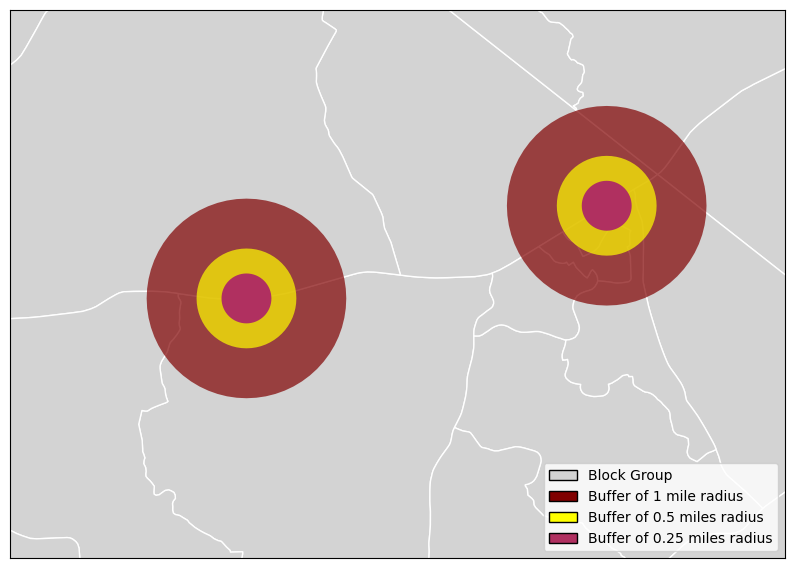

In [ ]:
from matplotlib.patches import Patch

# Plot for report
stations_buffer_one = gdf_stations.copy()
stations_buffer_half = gdf_stations.copy()
stations_buffer_quar = gdf_stations.copy()
stations_buffer_one.geometry = gdf_stations.geometry.buffer(5280)
stations_buffer_half.geometry = gdf_stations.geometry.buffer(2640)
stations_buffer_quar.geometry = gdf_stations.geometry.buffer(1320)
fig, ax1 = plt.subplots(figsize=(10, 12)) # Set the figure size
shp_tx.plot(ax=ax1, color='lightgrey', edgecolor="white")
stations_buffer_one.plot(ax=ax1, color="#800000", alpha=0.7)
stations_buffer_half.plot(ax=ax1, color='yellow', alpha=0.7)
stations_buffer_quar.plot(ax=ax1, color='#b03060')
plt.ylim((10028000,10057000))
plt.xlim((3009000,3050000))
# Create legend
legend_elements = [   Patch(facecolor='lightgrey', edgecolor='black', label='Block Group'),    
                   Patch(facecolor="#800000", edgecolor='black', label='Buffer of 1 mile radius'),    
                   Patch(facecolor='yellow', edgecolor='black', label='Buffer of 0.5 miles radius'),    
                   Patch(facecolor='#b03060', edgecolor='black', label='Buffer of 0.25 miles radius')
                   ]
plt.legend(handles=legend_elements, title='', loc='lower right')
ax1.set_xticks([]) # Use set_xticks on the Axes object, not on plt
ax1.set_yticks([]) # Use set_yticks on the Axes object, not on plt
plt.show()
